# 2.03c - Analysis of Night Clusters and BG Excursions
This notebook is used to analyse the night clusters and look for indications of BG control during the night by identifying BG excursions. The aim is to see if there are any patterns in the data that may indicate disturbances in sleep patterns, and to see if there are any differences between the night clusters.


In [56]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import time
from IPython.display import display

from src.nights import Nights, consolidate_df_from_nights
from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample_long = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample_long.get_consolidated_df()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)
analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start.hour)
analyser.extract_night_level_features(multi_threaded=False)
analyser.preprocess_night_features(n_components=2)
cluster_range = range(2,8)
kwargs = {'perplexity': 10, 'max_iter': 80000}
analyser.fit_tsne(**kwargs)
analyser.clustering_tsne(n_clusters=4)

df_all = analyser.return_dataset_with_clusters()
df_all = df_all[['night_start_date', 'bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max', 'tsne_cluster_label']].rename(columns={'tsne_cluster_label': 'cluster'})
bg_min = 70
bg_max = 180

def add_excursion_vars(df, var_name, bg_min, bg_max):
    min_name = 'min' if var_name == 'minmax' else 'mean'
    max_name = 'max' if var_name == 'minmax' else 'mean'
    df[f'bg_min_excursion_by_{min_name}'] = df[f'bg {min_name}'].apply(lambda x: (bg_min - x) if x < bg_min else np.nan)
    df[f'bg_max_excursion_by_{max_name}'] = df[f'bg {max_name}'].apply(lambda x: (x - bg_max) if x > bg_max else np.nan)

    def excursion_type(row):
        if pd.notna(row[f'bg_min_excursion_by_{min_name}']) and pd.notna(row[f'bg_max_excursion_by_{max_name}']):
            return 'IBR and IAR'
        elif pd.notna(row[f'bg_min_excursion_by_{min_name}']):
            return 'IBR'
        elif pd.notna(row[f'bg_max_excursion_by_{max_name}']):
            return 'IAR'
        else:
            return np.nan

    df['bg_excursion_type'] = (df[[f'bg_min_excursion_by_{min_name}', f'bg_max_excursion_by_{max_name}']].
                               apply(lambda x: excursion_type(x), axis=1))

    return df

# df_all['bg_min_excursion_by_min'] = df_all['bg min'].apply(lambda x: (bg_min - x) if x < bg_min else np.nan)
# df_all['bg_max_excursion_by_max'] = df_all['bg max'].apply(lambda x: (x - bg_max) if x > bg_max else np.nan)
# df_all['bg_min_excursion_by_mean'] = df_all['bg mean'].apply(lambda x: (bg_min - x) if x < bg_min else np.nan)
# df_all['bg_max_excursion_by_mean'] = df_all['bg mean'].apply(lambda x: (x - bg_max) if x > bg_max else np.nan)
#
# def excursion_type(row):
#     if pd.notna(row['bg_min_excursion_by_min']) and pd.notna(row['bg_max_excursion_by_max']):
#         return 'IBR and IAR'
#     elif pd.notna(row['bg_min_excursion_by_min']):
#         return 'IBR'
#     elif pd.notna(row['bg_max_excursion_by_max']):
#         return 'IAR'
#     else:
#         return np.nan
#
# df_all['bg_excursion_type'] = (df_all[['bg_min_excursion_by_min', 'bg_max_excursion_by_max']].
#                                apply(lambda x: excursion_type(x), axis=1))
df_all = add_excursion_vars(df_all, 'minmax', bg_min, bg_max)

2025-07-08 22:31:11.160 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
Number of nights objects created: 83


Feature Extraction:   0%|          | 0/6454 [00:00<?, ?it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:   8%|▊         | 544/6454 [00:00<00:04, 1357.24it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  11%|█         | 695/6454 [00:00<00:04, 1400.21it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning:

Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'iob max__count_above__t_100', 'cob max__minimum', 'cob mean__minimum'}
PCA reduced dimensions from 75 to 2.


BG excursion values are calculated as the difference between the BG min and max values and the target range of 70-180 mg/dL (3.9-10 mmol/l). In both cases, the value is calculated as an absolute value so that magnitude can be compared later on.

In [58]:
night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []
for zip_id, df_ind in df_all.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)

We'll first look to see if there is any prevalence of BG excursions in the night clusters. Sleep is considered key to maintaining optimal cardiovascular and metabolic health. The relationship between sleep and glyaecemic control is complex and bi-directional. The effects of disrupted sleep on glucose control \cite{Farabi2016} and - conversely - impact of diabetes treatment on sleep \cite{Brod2013} have been studied but require more research. For instance, studies have associated the rapid decline in blood glucose over short periods with awakenings from sleep \cite{Pillar2003}, but little is known about causation.

By studying the amount of excursions outside a target glucose range, we can get an idea as to the frequency and extent of these excursions. Based on the assumptions given by other research, such excursions may infer - by association - some form of disturbance of sleep. Setting accurate thresholds is not possible when generalising over individuals. Time in range is a good indicator of BG control, but the definition of the ideal range is highly individual. For adults in the UK the general guidance is a target range is between 3.9–10 mmol/l. There are a number of factors that can influence this range however, such as disease duration, comorbities, pregnancy and others \cite{ElSayed2023}. For instance, for individuals in gestation are guided by a 3.5–7.8 mmol/l range, yet we do not have data on most of these influences to personalise the target accordingly. A search of academic papers on guidance for fasting target ranges refers mainly to diagnosis levels rather than guidance for those with T1D though some important institutes do indicate a  and therefore assume a consistent 3.9-10 mmol/l (70-180 mg/dL) concentration range as a general guideline, but this would normally be adjusted for individual needs.

The period we will consider studying once more is the 22:00-06:00 period as defining an arbitrary 'nocturnal' period. This is a period where we would expect the patient to be asleep and therefore not consuming food or taking insulin. Given our intervals are at 30 minutes we cannot accurately measure TOR, but we can look at intervals outside the target range, as well as the level of excursion above or below the target. At each interval we can focus on the BG min and max values at each interval which will have captured the peaks and troughs without smoothing these values, especially if short-lived. We know the OpenAPS system effectively manages BG in patients, so we would expect to see a lower number of excursions in the night clusters compared to the day clusters.

,cluster,bg_excursion_type,bg_excursions
0,0,IAR,823
1,0,IBR,338
2,1,IAR,3035
3,1,IBR,156
4,2,IAR,1003
5,2,IBR,202
6,3,IAR,1149
7,3,IBR,490


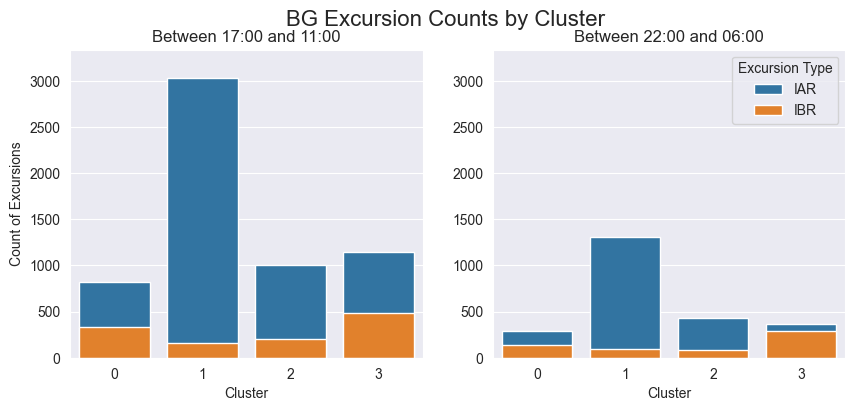

In [59]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.suptitle('BG Excursion Counts by Cluster', fontsize=16)
df_all_excursion_summary = df_all.groupby(['cluster', 'bg_excursion_type']).size().reset_index(name='bg_excursions')
display(df_all_excursion_summary)
df_overnight_excursion_summary = df_overnight.groupby(['cluster', 'bg_excursion_type'])['bg_excursion_type'].size().reset_index(name='bg_excursions')
y_max = df_all_excursion_summary['bg_excursions'].max()
sns.barplot(df_all_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[0], legend=False)
axes[0].set_title('Between 17:00 and 11:00')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count of Excursions')
axes[0].set_ylim(0, y_max * 1.1)

sns.barplot(df_overnight_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[1])
axes[1].set_title('Between 22:00 and 06:00')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel(None)
axes[1].set_ylim(0, y_max * 1.1)

axes[1].legend(title='Excursion Type')
plt.show()


In [60]:
def mean_excursions_by_night(df):
    excursions_per_night = (
        df.groupby(['id', 'night_start_date'])['bg_excursion_type']
        .apply(lambda x: x.notna().sum())
        .reset_index(name='excursion_count')
    )
    return excursions_per_night['excursion_count'].mean()

print(f'Mean excursions per night for 17:00-11:00 period (including zeros):{mean_excursions_by_night(df_all): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros):{mean_excursions_by_night(df_overnight): .2f}')

Mean excursions per night for 17:00-11:00 period (including zeros):  7.80
Mean excursions per night for 22:00-06:00 period (including zeros): 3.26


The plots show some interesting findings. Firstly, there are a significant number of excursions, more than had been expected. Secondly, there is a predominance of IAR excursions. Third, cluster 1 sees a significant number of IAR excursions (over 60% more), and cluster 3 sees more IBR excursions than other nights, though very few IAR excursions by comparison. However, these numbers are based on minimum and maximum values when resampled, giving no indication in the time out of range. Studies often use a time period of 15 minutes or upward to define an excursion, but this is not possible with the 30 minute intervals we have. By using the mean (aggregated from all readings in the 30 minute interval) we can get a better idea of the excursions, but this will not be entirely accurate as it may smooth out some of the excursions. Averaging these give us a slightly different picture, one would expect.

In [61]:
df_all_by_mean = add_excursion_vars(df_all, 'mean', bg_min, bg_max)
df_overnight_by_mean = add_excursion_vars(df_overnight, 'mean', bg_min, bg_max)
print('Mean excursions per night calculated using bg mean values:')
print(f'Mean excursions per night for 17:00-11:00 period (including zeros): {mean_excursions_by_night(df_all_by_mean): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros): {mean_excursions_by_night(df_overnight_by_mean): .2f}')


Mean excursions per night calculated using bg mean values:
Mean excursions per night for 17:00-11:00 period (including zeros):  6.55
Mean excursions per night for 22:00-06:00 period (including zeros):  2.78


In [62]:
# Per-night aggregation: stats and mutually exclusive flags
nightly = (
    df_overnight.groupby(['id', 'night_start_date'])
    .agg(
        max_excursion=('bg_max_excursion_by_max', 'max'),
        min_excursion=('bg_min_excursion_by_min', 'min'),
        IBR_night=('bg_excursion_type', lambda x: (x == 'IBR').any()),
        IAR_night=('bg_excursion_type', lambda x: (x == 'IAR').any()),
        excursion_count=('bg_excursion_type', lambda x: x.notna().sum()),
        IBR_count=('bg_excursion_type', lambda x: (x == 'IBR').sum()),
        IAR_count=('bg_excursion_type', lambda x: (x == 'IAR').sum())
    )
    .reset_index()
)
# Mutually exclusive flags
nightly['IBR_and_IAR_night'] = nightly['IBR_night'] & nightly['IAR_night']
nightly['IBR_only_night'] = nightly['IBR_night'] & ~nightly['IAR_night']
nightly['IAR_only_night'] = nightly['IAR_night'] & ~nightly['IBR_night']

# Per-patient aggregation
summary = (
    nightly.groupby('id')
    .agg(
        total_nights=('night_start_date', 'nunique'),
        nights_with_excursion=('excursion_count', lambda x: (x > 0).sum()),
        excursion_count=('excursion_count', 'sum'),
        IBR_count=('IBR_count', 'sum'),
        IAR_count=('IAR_count', 'sum'),
        max_excursion_mean=('max_excursion', 'mean'),
        min_excursion_mean=('min_excursion', 'mean'),
        nights_with_IBR=('IBR_only_night', 'sum'),
        nights_with_IAR=('IAR_only_night', 'sum'),
        nights_with_both_IBR_IAR=('IBR_and_IAR_night', 'sum')
    )
)

display(summary)

,total_nights,nights_with_excursion,excursion_count,IBR_count,IAR_count,max_excursion_mean,min_excursion_mean,nights_with_IBR,nights_with_IAR,nights_with_both_IBR_IAR
id,,,,,,,,,,
15558575,42,24,95,24,71,40.894737,5.333333,5,16,3
21946407,48,39,291,19,272,93.666667,9.000000,3,30,6
28768536,41,18,55,48,7,21.333333,3.500000,15,1,2
32407882,63,47,301,2,299,53.250000,2.000000,1,45,1
41131654,150,81,288,174,114,36.590909,4.921875,44,33,4
47323535,51,20,44,4,40,34.166667,8.031250,3,16,1
47750728,39,29,105,11,94,45.280000,4.222222,5,23,1
66836068,38,16,59,20,39,26.818182,4.000000,7,9,0
67208817,48,17,67,1,66,56.000000,8.000000,1,16,0


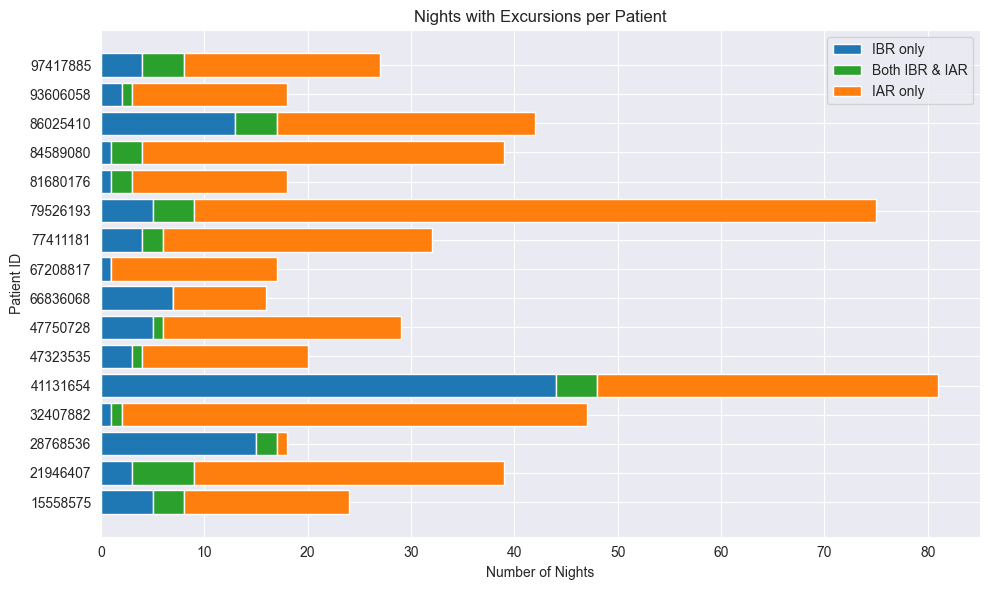

In [63]:
plot_df = summary[['nights_with_IBR', 'nights_with_IAR', 'nights_with_both_IBR_IAR']].copy()
plot_df.index = summary.index  # Ensure patient IDs are the index

fig, ax = plt.subplots(figsize=(10, 6))
ids = plot_df.index.astype(str)
bottom = None

ax.barh(ids, plot_df['nights_with_IBR'], label='IBR only', color='#1f77b4')
ax.barh(ids, plot_df['nights_with_both_IBR_IAR'],
        left=plot_df['nights_with_IBR'],
        label='Both IBR & IAR', color='#2ca02c')
ax.barh(ids, plot_df['nights_with_IAR'], left=plot_df['nights_with_IBR'] + plot_df['nights_with_both_IBR_IAR'], label='IAR only', color='#ff7f0e')

ax.set_xlabel('Number of Nights')
ax.set_ylabel('Patient ID')
ax.set_title('Nights with Excursions per Patient')
ax.legend()
plt.tight_layout()
plt.show()

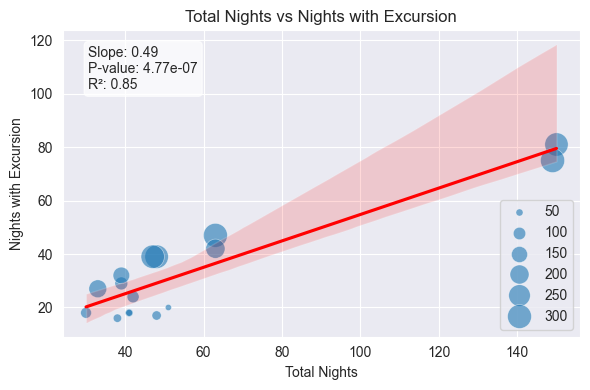

In [64]:
from scipy.stats import linregress

# Prepare data
x = summary['total_nights']
y = summary['nights_with_excursion']

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value ** 2

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    summary, x='total_nights', y='nights_with_excursion',
    size='excursion_count', sizes=(20, 300), alpha=0.6, ax=ax
)
sns.regplot(
    summary, x='total_nights', y='nights_with_excursion',
    scatter=False, ax=ax, color='red', line_kws={'label': 'Fit Line'}
)

# Annotate with coefficient, p-value, and R²
ax.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nP-value: {p_value:.3g}\nR²: {r_squared:.2f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

plt.title('Total Nights vs Nights with Excursion')
plt.xlabel('Total Nights')
plt.ylabel('Nights with Excursion')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

The first and most notable observation is the high number of excursions that exist, following a linear relationship between the number of nights and the number of excursions. This is not unexpected, as the more nights we have, the more likely we are to have excursions. However, the slope of this line is quite high (with p-value < 5% and R^2 of 0.91), indicating that the number of excursions does increase significantly with the number of nights. This would suggest that this form of indicator will not be particularly accurate at highlighting disturbances in diurnal patterns per se, but rather that the number of excursions is a function of the number of nights. This is not unexpected, as the more nights we have, the more likely we are to have excursions. However, the slope of this line is quite high (with p-value < 5% and R^2 of 0.91), indicating that the number of excursions does increase significantly with the number of nights. This would suggest that this form of indicator will not be particularly accurate at highlighting disturbances in diurnal patterns per se, but rather that the number of excursions is simply a function of the number of nights.

In [65]:
from src.helper import rank_minutes_series

df_hist_excursion = df_overnight[['cluster', 'bg_min_excursion_by_min', 'bg_max_excursion_by_max']].reset_index().copy()
df_hist_excursion['time'] = df_hist_excursion['datetime'].dt.time
df_hist_excursion['time_rank'] = rank_minutes_series(df_hist_excursion['time'], night_start)
df_hist_excursion = (df_hist_excursion.
                     rename(columns={'bg_min_excursion_by_min': 'IBR', 'bg_max_excursion_by_max': 'IAR'}).
                     melt(id_vars=['cluster', 'time', 'time_rank'],
                          value_vars=['IBR', 'IAR'],
                          var_name='excursion_type',
                          value_name='excursion_value').
                     dropna(subset=['excursion_value']).
                     sort_values(by='time_rank'))
xticks = df_hist_excursion[['time_rank','time']].set_index('time_rank').drop_duplicates().sort_index()['time']

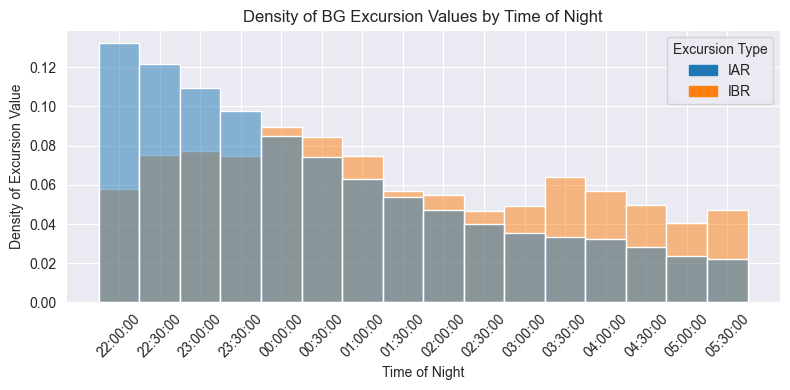

In [66]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(8, 4))
ax = plt.gca()
palette = sns.color_palette(n_colors=df_hist_excursion['excursion_type'].nunique())
excursion_types = df_hist_excursion['excursion_type'].unique()

sns.histplot(
    df_hist_excursion, x='time_rank', hue='excursion_type', weights='excursion_value',
    stat='density', common_norm=False, binwidth=30, discrete=True, ax=ax, palette=palette
)

plt.xticks(ticks=df_hist_excursion['time_rank'].unique(), labels=xticks, rotation=45)
plt.xlabel('Time of Night')
plt.ylabel('Density of Excursion Value')
plt.title('Density of BG Excursion Values by Time of Night')

# Custom legend handles
handles = [
    mpatches.Patch(color=palette[i], label=excursion_types[i])
    for i in range(len(excursion_types))
]
plt.legend(handles=handles, title='Excursion Type')

plt.tight_layout()
plt.show()

The density of the excursion value in histogram shows how the magnitude of blood glucose excursions (either IBR or IAR) is distributed across different time intervals during the night, for each cluster. Density means the plot is normalised so the area under the curve (or sum of bar heights) equals 1 for each group, allowing comparison of the shape of the distribution, regardless of the total number or sum of excursions. The excursion value is the amount by which blood glucose is outside the target range (either above or below). It provides a view of the times excursions are more or less likely, and how large they tend to be.

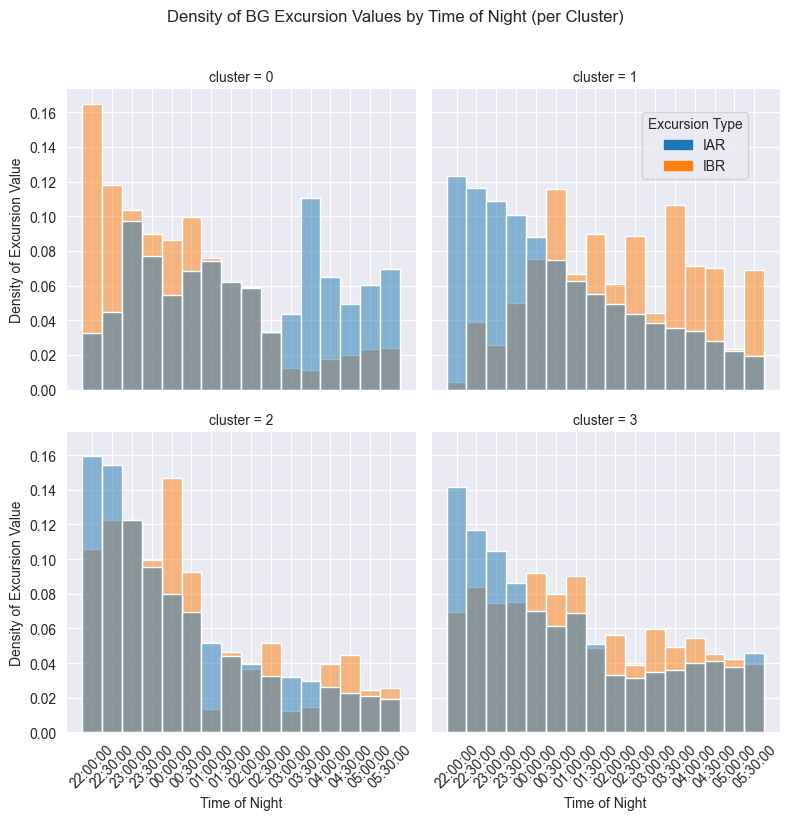

In [67]:
# Create the FacetGrid
g = sns.FacetGrid(
    df_hist_excursion,
    col='cluster',
    col_wrap=2,
    height=4,
    sharey=True
)
g.map_dataframe(
    sns.histplot,
    x='time_rank',
    hue='excursion_type',
    weights='excursion_value',
    stat='density',
    common_norm=False,
    binwidth=30,
    discrete=True,
    legend=False
)
for ax in g.axes.flatten():
    ax.set_xticks(df_hist_excursion['time_rank'].unique())
    ax.set_xticklabels(xticks, rotation=45)
    ax.set_xlabel('Time of Night')
    ax.set_ylabel('Density of Excursion Value')

# Get the actual palette used by the FacetGrid
palette = g._legend_data if hasattr(g, '_legend_data') else None
if palette:
    handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
else:
    # fallback: use unique types and default palette
    excursion_types = df_hist_excursion['excursion_type'].unique()
    colors = sns.color_palette(n_colors=len(excursion_types))
    handles = [mpatches.Patch(color=colors[i], label=etype) for i, etype in enumerate(excursion_types)]

g.fig.legend(handles=handles, title='Excursion Type', loc='upper right', bbox_to_anchor=(0.95, 0.9))

g.fig.suptitle('Density of BG Excursion Values by Time of Night (per Cluster)', y=1.02)
plt.tight_layout()
plt.show()

As we can see here, the distribution of excursion values for IAR over cluster 1, 2, 3 contribute to the overall distribution that starts with a peak and tails off towards the end of the night. This would naturally be expected as the patient is likely to be asleep and not consuming food or taking insulin. Cluster 0 however is more noisy, and it is IBR that has a more distinct distribution, akin to that of IBR in other clusters. IBR in general is more noisy, but the distribution is more pronounced in cluster 0. This may indicate that the patient is more likely to have IBR during the night, which may be indicative of a disturbance in their sleep pattern.

## Level 2 Hypoglycaemia and Hyperglycaemia Thresholds
There are two other thresholds that exist given their consideration as clinically significant. These are the level 2 hypoglycaemia threshold of 54 mg/dL (3.0 mmol/l) and the level 2 hyperglycaemia threshold of 250 mg/dL (13.9 mmol/l). These thresholds are used to indicate more severe excursions that may require intervention, such as a glucagon injection or insulin bolus. We can look at the number of excursions that occur outside these thresholds, and see if there is any difference between the night clusters.

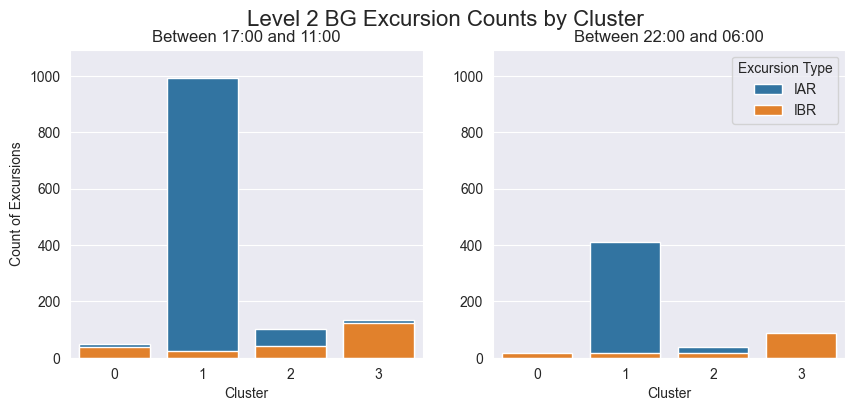

In [69]:
bg_min = 54
bg_max = 250
df_all_level2 = add_excursion_vars(df_all, 'minmax', bg_min, bg_max)
df_overnight_level2 = add_excursion_vars(df_overnight, 'minmax', bg_min, bg_max)
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.suptitle('Level 2 BG Excursion Counts by Cluster', fontsize=16)
df_all_level2_excursion_summary = df_all_level2.groupby(['cluster', 'bg_excursion_type']).size().reset_index(name='bg_excursions')
df_overnight_level2_excursion_summary = df_overnight_level2.groupby(['cluster', 'bg_excursion_type'])['bg_excursion_type'].size().reset_index(name='bg_excursions')
y_max = df_all_level2_excursion_summary['bg_excursions'].max()
sns.barplot(df_all_level2_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[0], legend=False)
axes[0].set_title('Between 17:00 and 11:00')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count of Excursions')
axes[0].set_ylim(0, y_max * 1.1)
sns.barplot(df_overnight_level2_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[1])
axes[1].set_title('Between 22:00 and 06:00')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel(None)
axes[1].set_ylim(0, y_max * 1.1)
axes[1].legend(title='Excursion Type')
plt.show()


In [71]:
print(f'Mean excursions per night for 17:00-11:00 period (including zeros):{mean_excursions_by_night(df_all): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros):{mean_excursions_by_night(df_overnight): .2f}')

Mean excursions per night for 17:00-11:00 period (including zeros): 1.64
Mean excursions per night for 22:00-06:00 period (including zeros): 0.68
